In [1]:
import pandas as pd
import numpy as np
import os
import pickle
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix, r2_score
from data_loader import get_identifier
import matplotlib.pyplot as plt

def read_validation_additional_lines_labels():
    df = pd.read_csv('additional_lines_labels.csv', index_col=0, dtype='str')
    df.index = [tuple(n.split('_')) for n in df.index]
    mapping = {'0': 0.,
               '0*': 0.,
               '0(0.5)': 0.2,
               '0(1)': 0.4,
               '0/1': 0.4,
               '0(1.5)': 0.6,
               '0(1.5/2)': 0.8,
               '0(2)': 0.8,
               '0(2)*': 0.8,
               '1': 1.,
               '1*': 1.,
               'nan': np.nan,}
    for col in df:
        values = [mapping[v] if v == v else np.nan for v in df[col]]
        df[col] = values
    return df


def read_other_instrument_line_labels():
    df = pd.read_csv('other_instrument_labels.csv', index_col=0)
    return df


def evaluate_confmat(y_trues, y_preds, soft=True):
    conf_mat = np.zeros((6, 4))
    for y_true, y_pred in zip(y_trues, y_preds):
        label = int(np.round(y_true * 5))
        if soft:
            conf_mat[label] += y_pred.reshape((4,))
        else:
            conf_mat[label, np.argmax(y_pred)] += 1
    conf_mat = conf_mat / conf_mat.sum(1, keepdims=True)
    return conf_mat
    

def evaluate_binary_metric(y_trues, y_preds, cutoff=1):
    _y_preds = y_preds[:, cutoff:].sum(1)
    _y_trues = y_trues

    s1 = precision_score(_y_trues, _y_preds > 0.5)
    s2 = recall_score(_y_trues, _y_preds > 0.5)
    s3 = f1_score(_y_trues, _y_preds > 0.5)
    s4 = roc_auc_score(_y_trues, _y_preds)
    print("Prec: %.3f\tRecall: %.3f\tF1: %.3f\tAUC: %.3f" % (s1, s2, s3, s4))
    return s1, s2, s3, s4


def boxplot_pred_distri(y_trues, 
                        y_preds, 
                        properties, 
                        cutoff=1,
                        boxplot_fig_output='pred_distri.png',
                        samplect_fig_output='sample_count.png'):
    _y_preds = y_preds[:, cutoff:].sum(1)
    _y_trues = y_trues

    x_axis = sorted(set(properties))

    pred_neg = {i: [] for i in x_axis}
    pred_pos = {i: [] for i in x_axis}
    for pred, label, prop in zip(_y_preds, _y_trues, properties):
        if label == 0:
            pred_neg[prop].append(pred)
        elif label == 1:
            pred_pos[prop].append(pred)
        else:
            raise ValueError

    plt.clf()
    fig, ax = plt.subplots(figsize=(7, 3))
    red_diamond = dict(markerfacecolor='r', marker='D', markersize=2)
    data = [pred_pos[_x] for _x in x_axis]
    bplot_pos = ax.boxplot(
        data,
        notch=True,
        vert=True,
        patch_artist=True,
        positions=np.arange(len(x_axis))+0.11,
        flierprops=red_diamond,
        widths=0.2,
        manage_ticks=False)
    blue_diamond = dict(markerfacecolor='b', marker='D', markersize=2)
    data = [pred_neg[_x] for _x in x_axis]
    bplot_neg = ax.boxplot(
        data,
        notch=True,
        vert=True,
        patch_artist=True,
        positions=np.arange(len(x_axis))-0.11,
        flierprops=blue_diamond,
        widths=0.2,
        manage_ticks=False)
    ax.set_xticks(np.arange(len(x_axis)))
    ax.set_xticklabels(x_axis)
    ax.set_xlim(-1, len(x_axis))
    ax.set_ylim([-0.03, 1.03])
    for patch in bplot_pos['boxes']:
        patch.set_facecolor('pink')
    for patch in bplot_neg['boxes']:
        patch.set_facecolor('lightblue')
    ax.set_title('Prediction Distribution')
    plt.savefig(boxplot_fig_output, dpi=300, bbox_inches='tight')

    plt.clf()
    fig, ax = plt.subplots(figsize=(7, 1.5))
    ax.plot(np.arange(len(x_axis)), [len(pred_pos[_x]) for _x in x_axis], c='pink')
    ax.plot(np.arange(len(x_axis)), [len(pred_neg[_x]) for _x in x_axis], c='lightblue')
    ax.set_xticks(np.arange(len(x_axis)))
    ax.set_xticklabels(x_axis)
    ax.set_xlim(-1, len(x_axis))
    ax.set_ylim([0, ax.get_ylim()[1]])
    plt.savefig(samplect_fig_output, dpi=300, bbox_inches='tight')

    
def load_cla_pred_as_dict(path):
    pred_file = os.path.join(path, 'cla.pkl')
    preds = pickle.load(open(pred_file, 'rb'))
    pred_dict = dict(zip([get_identifier(n) for n in preds['pred_names']], preds['cla_preds']))
    return pred_dict


Matplotlib created a temporary config/cache directory at /tmp/matplotlib-z5ui5tx2 because the default path (/home/zqwu/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
additional_lines = [
    'pred_save/additional_lines/line_477/ex0/',
    'pred_save/additional_lines/line_202/ex0/',
    'pred_save/additional_lines/line_20/ex0/',
    'pred_save/additional_lines/line_100/ex3/',
    'pred_save/additional_lines/line_142/ex1/',
    'pred_save/additional_lines/line_273/ex2/',
    'pred_save/additional_lines/line_839/ex1/',
    'pred_save/additional_lines/line_480/ex0/',
    'pred_save/additional_lines/line_854/ex0/',
    'pred_save/additional_lines/line_975/ex0/',
]

pred_file_names = [
    'ex-valid-pred-to-18',
    'ex-test-pred-to-17',
    'ex-test-pred-to-18',
]

label_df = read_validation_additional_lines_labels()
label_cutoff = 0.5
pred_cutoff = 2
exclude_ambiguous = False

In [3]:
roc_auc_curves = {}
pred_val_df = {}
for line in additional_lines:
    line_name = get_identifier(line)[0].split('_')[1]
    label_dict = dict(zip(label_df.index, label_df[line_name]))
    
    pred_val_df = pd.DataFrame({'label': label_df[line_name]})
    pred_val_df.index = label_df.index

    pos_rate = (np.array(list(label_dict.values())) > label_cutoff).mean()
    if pos_rate == 0. or pos_rate == 1.:
        continue
    
    pred_dicts = [load_cla_pred_as_dict(os.path.join(line, pred_file_name)) for pred_file_name in pred_file_names]
    
    print("line %s, pos rate %.2f" % (line_name, pos_rate))
    curve = {}
    for day in np.arange(4, 12):
        _pred_dicts = [{k[-2:]: v for k, v in pd.items() if int(k[2]) == day} for pd in pred_dicts]
        shared_keys = sorted(set(_pred_dicts[0].keys()) & set(label_dict.keys()))
        shared_keys = [k for k in shared_keys if label_dict[k] == label_dict[k]]
        if exclude_ambiguous:
            shared_keys = [k for k in shared_keys if np.round(label_dict[k]) == label_dict[k]]
        if len(shared_keys) > 100:
            y_trues = np.array([label_dict[k] for k in shared_keys]) > label_cutoff
            y_preds = np.stack([np.stack([pd[k] for k in shared_keys], 0) for pd in _pred_dicts], 0).mean(0)
            res = evaluate_binary_metric(y_trues, y_preds, cutoff=pred_cutoff)
            curve[int(day)] = res[-1]
            pred_val_df['D%d_pred' % day] = [np.mean([pd[k][pred_cutoff:].sum() for pd in _pred_dicts]) if k in _pred_dicts[0] else np.nan for k in label_df.index]
    
    pred_val_df.to_csv('pred_save/additional_lines/%s_preds.csv' % line_name)
    roc_auc_curves[line_name] = curve
    

line 477, pos rate 0.50
Prec: 0.528	Recall: 0.852	F1: 0.652	AUC: 0.649
Prec: 0.550	Recall: 0.807	F1: 0.654	AUC: 0.661
Prec: 0.828	Recall: 0.361	F1: 0.503	AUC: 0.777
Prec: 0.973	Recall: 0.732	F1: 0.836	AUC: 0.967
Prec: 0.989	Recall: 0.847	F1: 0.913	AUC: 0.980
Prec: 0.996	Recall: 0.965	F1: 0.981	AUC: 0.998
Prec: 0.993	Recall: 0.989	F1: 0.991	AUC: 1.000
Prec: 0.991	Recall: 0.998	F1: 0.995	AUC: 1.000
line 202, pos rate 0.31
Prec: 0.422	Recall: 0.648	F1: 0.511	AUC: 0.522
Prec: 0.441	Recall: 0.462	F1: 0.451	AUC: 0.635
Prec: 0.597	Recall: 0.612	F1: 0.604	AUC: 0.745
Prec: 0.972	Recall: 0.305	F1: 0.464	AUC: 0.929
Prec: 0.976	Recall: 0.355	F1: 0.521	AUC: 0.955
Prec: 0.947	Recall: 0.213	F1: 0.348	AUC: 0.866
Prec: 0.840	Recall: 0.420	F1: 0.560	AUC: 0.871
Prec: 0.629	Recall: 0.512	F1: 0.564	AUC: 0.786
line 20, pos rate 0.88
Prec: 0.918	Recall: 0.753	F1: 0.827	AUC: 0.294
Prec: 0.943	Recall: 0.821	F1: 0.878	AUC: 0.710
Prec: 0.945	Recall: 0.868	F1: 0.905	AUC: 0.799
Prec: 0.960	Recall: 0.752	F1: 0.844	

In [4]:
print(pred_file_names)
pred_dicts = {line: [load_cla_pred_as_dict(os.path.join(line, pred_file_name)) for pred_file_name in pred_file_names] \
              for line in additional_lines}
comb_curve = {}
conf_mats = {}
all_preds = []
all_trues = []
all_days = []
for day in np.arange(4, 12):
    y_preds = []
    y_trues = []
    for line in additional_lines:
        line_name = get_identifier(line)[0].split('_')[1]
        label_dict = dict(zip(label_df.index, label_df[line_name]))

        pds = pred_dicts[line]
        _pds = [{k[-2:]: v for k, v in pd.items() if int(k[2]) == day} for pd in pds]
        shared_keys = sorted(set(_pds[0].keys()) & set(label_dict.keys()))
        shared_keys = [k for k in shared_keys if label_dict[k] == label_dict[k]]
        if len(shared_keys) > 100:
            y_trues.append(np.array([label_dict[k] for k in shared_keys]))
            y_preds.append(np.stack([np.stack([d[k] for k in shared_keys], 0) for d in _pds], 0).mean(0))
    y_trues = np.concatenate(y_trues)
    y_preds = np.concatenate(y_preds)

    all_trues.append(y_trues)
    all_preds.append(y_preds)
    all_days.extend([day] * len(y_trues))

    conf_mats[day] = evaluate_confmat(y_trues, y_preds, soft=False)
    comb_curve[day] = evaluate_binary_metric(y_trues > label_cutoff, y_preds, cutoff=pred_cutoff)[-1]

['ex-valid-pred-to-18', 'ex-test-pred-to-17', 'ex-test-pred-to-18']
Prec: 0.655	Recall: 0.757	F1: 0.702	AUC: 0.686
Prec: 0.699	Recall: 0.757	F1: 0.727	AUC: 0.748
Prec: 0.780	Recall: 0.664	F1: 0.717	AUC: 0.759
Prec: 0.865	Recall: 0.652	F1: 0.744	AUC: 0.845
Prec: 0.924	Recall: 0.680	F1: 0.783	AUC: 0.891
Prec: 0.911	Recall: 0.710	F1: 0.798	AUC: 0.902
Prec: 0.933	Recall: 0.760	F1: 0.838	AUC: 0.929
Prec: 0.916	Recall: 0.805	F1: 0.857	AUC: 0.930


<Figure size 432x288 with 0 Axes>

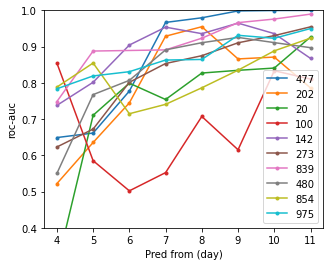

In [5]:
plt.clf()
plt.figure(figsize=(5, 4))
for line, curve in roc_auc_curves.items():
    x = sorted(curve.keys())
    y = [curve[_x] for _x in x]
    plt.plot(x, y, '.-', label=line)
plt.legend()
plt.ylim(0.4, 1.0)
plt.xlabel("Pred from (day)")
plt.ylabel("roc-auc")
#plt.show()
plt.savefig("pred_save/additional_lines/roc_auc_curves.png", dpi=300, bbox_inches='tight')


<Figure size 360x288 with 0 Axes>

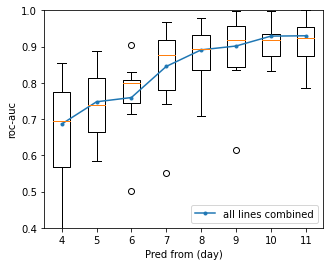

In [6]:
scores_by_day = {}
plt.figure(figsize=(5, 4))
for line, curve in roc_auc_curves.items():
    x = sorted(curve.keys())
    for _x in x:
        if not _x in scores_by_day:
            scores_by_day[_x] = []
        scores_by_day[_x].append(curve[_x])
plt.clf()
plt.figure(figsize=(5, 4))
plt.boxplot([scores_by_day[x] for x in np.arange(4, 12)], positions=np.arange(4, 12))
plt.ylim(0.4, 1.0)
plt.xlabel("Pred from (day)")
plt.ylabel("roc-auc")

plt.plot(np.arange(4, 12), [comb_curve[i] for i in np.arange(4, 12)], '.-', label='all lines combined')
plt.ylim(0.4, 1.0)
plt.legend()
#plt.show()
plt.savefig("pred_save/additional_lines/roc_auc_box.png", dpi=300, bbox_inches='tight')

In [ ]:
for day in np.arange(4, 12):
    conf_mat = conf_mats[day]
    plt.clf()
    plt.imshow(conf_mats[day], cmap='viridis', vmin=0., vmax=0.6)
    for i, row in enumerate(conf_mat):
        for j, val in enumerate(row):
            plt.text(j, i,"%.2f" % val,ha='center', va='center')
    plt.yticks([0, 1, 2, 3, 4, 5], ['0', '0(0.5)', '0(1)', '0(1.5)', '0(2)', '1'])
    plt.title("Confusion matrix (Day %d)" % day)
    plt.savefig("pred_save/additional_lines/conf_mat_day%d.png" % day, dpi=300, bbox_inches='tight')

In [ ]:
boxplot_pred_distri(np.concatenate(all_trues) > 0.5, 
                    np.concatenate(all_preds, 0), 
                    all_days,
                    cutoff=2,
                    boxplot_fig_output='pred_save/additional_lines/pred_distri.png',
                    samplect_fig_output='pred_save/additional_lines/sample_count.png')

Prec: 0.800	Recall: 0.291	F1: 0.427	AUC: 0.747
Prec: 0.878	Recall: 0.655	F1: 0.750	AUC: 0.823
Prec: 0.872	Recall: 0.745	F1: 0.804	AUC: 0.838
Prec: 0.918	Recall: 0.818	F1: 0.865	AUC: 0.868
Prec: 0.927	Recall: 0.927	F1: 0.927	AUC: 0.895
Prec: 0.944	Recall: 0.927	F1: 0.936	AUC: 0.954
Prec: 0.945	Recall: 0.945	F1: 0.945	AUC: 0.968
Prec: 0.927	Recall: 0.927	F1: 0.927	AUC: 0.945
Prec: 0.893	Recall: 0.909	F1: 0.901	AUC: 0.911


<Figure size 432x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 504x216 with 0 Axes>

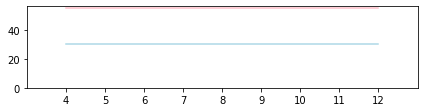

In [11]:
label_df = read_other_instrument_line_labels()
label_dict = dict(zip(label_df.index, label_df['Final Label']))

line = 'pred_save/other_instrument/ex2_other_instrument/'
pred_file_names = [
    'ex-valid-pred-to-18',
    'ex-test-pred-to-17',
    'ex-test-pred-to-18',
]

pred_cutoff = 2
pred_dicts = [load_cla_pred_as_dict(os.path.join(line, pred_file_name)) for pred_file_name in pred_file_names]

curve = {}
pred_val_df = pd.DataFrame({'label': label_df['Final Label']})
pred_val_df.index = label_df.index

all_trues = []
all_preds = []
all_days = []
for day in np.arange(4, 13):
    
    _pds = [{k[-2]: v for k, v in pd.items() if int(k[2]) == day} for pd in pred_dicts]
    shared_keys = sorted(set(_pds[0].keys()) & set(label_dict.keys()))
    shared_keys = [k for k in shared_keys if label_dict[k] == label_dict[k]]
    
    y_trues = np.array([label_dict[k] for k in shared_keys])
    y_preds = np.stack([np.stack([d[k] for k in shared_keys], 0) for d in _pds], 0).mean(0)
    curve[day] = evaluate_binary_metric(y_trues, y_preds, cutoff=pred_cutoff)[-1]
    pred_val_df['D%d_pred' % day] = \
        [np.mean([d[k][pred_cutoff:].sum() for d in _pds]) if k in _pds[0] else np.nan for k in label_df.index]
    
    all_trues.append(y_trues)
    all_preds.append(y_preds)
    all_days.extend([day] * len(y_trues))

pred_val_df.to_csv('pred_save/other_instrument/preds.csv')

x = np.arange(4, 13)
y = [curve[_x] for _x in x]
plt.clf()
plt.figure(figsize=(5, 4))
plt.plot(x, y, '.-')
plt.ylim(0.4, 1.0)
plt.xlabel("Pred from (day)")
plt.ylabel("roc-auc")
plt.savefig('pred_save/other_instrument/roc_auc_curve.png', dpi=300, bbox_inches='tight')

boxplot_pred_distri(np.concatenate(all_trues), 
                    np.concatenate(all_preds, 0), 
                    all_days,
                    cutoff=pred_cutoff,
                    boxplot_fig_output='pred_save/other_instrument/pred_distri.png',
                    samplect_fig_output='pred_save/other_instrument/sample_count.png')

Prec: 0.781	Recall: 0.155	F1: 0.259	AUC: 0.672
Prec: 0.774	Recall: 0.298	F1: 0.430	AUC: 0.761
Prec: 0.885	Recall: 0.429	F1: 0.577	AUC: 0.855
Prec: 0.741	Recall: 0.373	F1: 0.496	AUC: 0.790
Prec: 0.829	Recall: 0.571	F1: 0.676	AUC: 0.864
Prec: 0.824	Recall: 0.640	F1: 0.720	AUC: 0.889
Prec: 0.768	Recall: 0.739	F1: 0.753	AUC: 0.889
Prec: 0.812	Recall: 0.776	F1: 0.794	AUC: 0.929
Prec: 0.706	Recall: 0.820	F1: 0.759	AUC: 0.903


<Figure size 432x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 504x216 with 0 Axes>

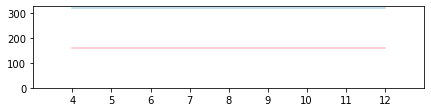

In [106]:
line = 'pred_save/prospective/ex2_prospective/'
pred_file_names = [
    'ex-valid-pred-to-18',
    'ex-test-pred-to-17',
    'ex-test-pred-to-18',
]

label_dict = pickle.load(open('pred_save/prospective/labels.pkl', 'rb'))
label_dict = {k: v[0] for k, v in label_dict.items() if v[1] > 0}

pred_cutoff = 2
pred_dicts = [load_cla_pred_as_dict(os.path.join(line, pred_file_name)) for pred_file_name in pred_file_names]

curve = {}
pred_val_df = pd.DataFrame({'label': [label_dict[k][pred_cutoff:].sum() for k in sorted(label_dict.keys())]})
pred_val_df.index = sorted(label_dict.keys())

all_trues = []
all_preds = []
all_days = []
for day in np.arange(4, 13):
    
    _pds = [{k[-2:]: v for k, v in pd.items() if int(k[2]) == day} for pd in pred_dicts]
    
    shared_keys = sorted(set(_pds[0].keys()) & set(label_dict.keys()))
    #shared_keys = [k for k in shared_keys if k[1] == '5']
    
    if len(shared_keys) > 10:
        y_trues = np.array([label_dict[k][pred_cutoff:].sum() > 0.5 for k in shared_keys])
        y_preds = np.stack([np.stack([d[k] for k in shared_keys], 0) for d in _pds], 0).mean(0)
        curve[day] = evaluate_binary_metric(y_trues, y_preds, cutoff=pred_cutoff)[-1]
        pred_val_df['D%d_pred' % day] = \
            [np.mean([d[k][pred_cutoff:].sum() for d in _pds]) if k in _pds[0] else np.nan for k in pred_val_df.index]
    
        all_trues.append(y_trues)
        all_preds.append(y_preds)
        all_days.extend([day] * len(y_trues))

pred_val_df.to_csv('pred_save/prospective/preds.csv')

x = sorted(curve.keys())
y = [curve[_x] for _x in x]
plt.clf()
plt.figure(figsize=(5, 4))
plt.plot(x, y, '.-')
plt.ylim(0.4, 1.0)
plt.xlabel("Pred from (day)")
plt.ylabel("roc-auc")
plt.savefig('pred_save/prospective/roc_auc_curve.png', dpi=300, bbox_inches='tight')

boxplot_pred_distri(np.concatenate(all_trues), 
                    np.concatenate(all_preds, 0), 
                    all_days,
                    cutoff=pred_cutoff,
                    boxplot_fig_output='pred_save/prospective/pred_distri.png',
                    samplect_fig_output='pred_save/prospective/sample_count.png')

In [2]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
os.environ['SM_FRAMEWORK'] = 'tf.keras'
import pickle
import numpy as np
import scipy
import tifffile
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix, r2_score

from data_loader import get_identifier, get_ex_day
from models import Segment, ClassifyOnSegment
from layers import load_partial_weights, fill_first_layer, evaluate_confusion_mat, summarize_conf_mat
from data_generator import CustomGenerator, PairGenerator, enhance_weight_for_false_positives

def get_day(n):
    return int(get_identifier(n)[2])

def plot_seg_pearsonr(rs_seg_preds, rs_seg_trues, properties, fig_output='seg_pearsonr.png'):

    props = np.array(properties)
    x_axis = sorted(set(properties))

    prs = []
    for _x in x_axis:
        _preds = rs_seg_preds[np.where(props == _x)]
        _trues = rs_seg_trues[np.where(props == _x)]
        prs.append(pearsonr(_preds, _trues)[0])

    plt.clf()
    fig, ax = plt.subplots(figsize=(7, 3))
    ax.plot(np.arange(len(x_axis)), prs, '.-')
    ax.set_xticks(np.arange(len(x_axis)))
    ax.set_xticklabels(x_axis)
    plt.savefig(fig_output, dpi=300, bbox_inches='tight')


def boxplot_seg_pearsonr_distri(prs, 
                                properties,
                                boxplot_fig_output='seg_pearsonr_distri.png',
                                samplect_fig_output='seg_sample_count.png'):

    x_axis = sorted(set(properties))

    prs_by_x = {_x: [] for _x in x_axis}
    for pr, prop in zip(prs, properties):
        if pr == pr:
            prs_by_x[prop].append(pr)

    plt.clf()
    fig, ax = plt.subplots(figsize=(7, 3))
    red_diamond = dict(markerfacecolor='r', marker='D', markersize=2)
    data = [prs_by_x[_x] for _x in x_axis]
    bplot = ax.boxplot(
        data,
        notch=True,
        vert=True,
        patch_artist=True,
        positions=np.arange(len(x_axis)),
        flierprops=red_diamond,
        widths=0.2,
        manage_ticks=False)
    ax.set_xticks(np.arange(len(x_axis)))
    ax.set_xticklabels(x_axis)
    ax.set_xlim(-1, len(x_axis))
    plt.savefig(boxplot_fig_output, dpi=300, bbox_inches='tight')

    plt.clf()
    fig, ax = plt.subplots(figsize=(7, 1.5))
    ax.plot(np.arange(len(x_axis)), [len(prs_by_x[_x]) for _x in x_axis], c='pink')
    ax.set_xticks(np.arange(len(x_axis)))
    ax.set_xticklabels(x_axis)
    ax.set_xlim(-1, len(x_axis))
    ax.set_ylim([0, ax.get_ylim()[1]])
    plt.savefig(samplect_fig_output, dpi=300, bbox_inches='tight')


def get_ind(name, gen):
    for k in gen.names:
        if gen.names[k] == name:
            return k
    return None

Segmentation Models: using `tf.keras` framework.


In [ ]:
root = '/oak/stanford/groups/jamesz/zqwu/iPSC_data/VALIDATION/line_combined-for-seg/ex2-14/0-to-0'
# root = '/oak/stanford/groups/jamesz/zqwu/iPSC_data/TRAIN/0-to-0_continuous/l1ex7_valid'

name_file = os.path.join(root, "names.pkl")
X_ct = len([f for f in os.listdir(root) if f.startswith('X_')])
X_files = [os.path.join(root, "X_%d.pkl" % i) for i in range(X_ct)]

segment_y_files = [os.path.join(root, "segment_continuous_y_%d.pkl" % i) for i in range(X_ct)]
segment_w_files = [os.path.join(root, "segment_continuous_w_%d.pkl" % i) for i in range(X_ct)]
classify_label_file = os.path.join(root, "classify_continuous_labels.pkl")
valid_gen = CustomGenerator(
    name_file,
    X_files, 
    segment_y_files=segment_y_files, 
    segment_w_files=segment_w_files,
    n_segment_classes=4,
    segment_class_weights=[1, 1, 1, 1],
    segment_label_type='continuous',
    classify_label_file=classify_label_file,
    n_classify_classes=4,
    classify_class_weights=[1, 1, 1, 1],
    classify_label_type='continuous')

/home/zqwu/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


<Figure size 432x288 with 0 Axes>

<Figure size 504x216 with 0 Axes>

<Figure size 504x108 with 0 Axes>

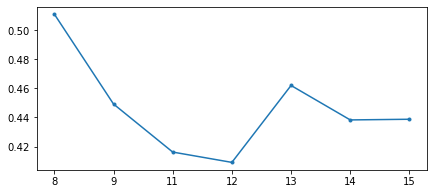

In [120]:
pred_root = '/oak/stanford/groups/jamesz/zqwu/iPSC_data/VALIDATION/line_combined-for-seg/ex2-14/ex-valid-pred-to-0'
# pred_root = '/oak/stanford/groups/jamesz/zqwu/iPSC_data/VALIDATION/line1_3R/ex7_0-to-0_test/weights.21-to-0'

rs_seg_preds = []
rs_seg_trues = []
rs_days = []

pearsonrs = []
days = []
day14_samples = []

fs = [f for f in os.listdir(pred_root) if f.startswith('seg_') and f.endswith('.pkl')]
for f in sorted(fs, key=lambda x: int(x.split('_')[1].split('.')[0])):
    dat = pickle.load(open(os.path.join(pred_root, f), 'rb'))
    seg_preds = dat['seg_preds']
    seg_trues = dat['seg_trues']
    seg_ws = dat['seg_ws']
    pred_names = dat['pred_names']
    for i, (s_pred, name) in enumerate(zip(seg_preds, pred_names)):

        name = name[0] if isinstance(name, tuple) else name
        day = get_day(name)
        ind = get_ind(name, valid_gen)
        
        X, y, w, name = valid_gen.load_ind(ind)
        if y is None or w is None:
            continue
        s_true = y[..., 1] + y[..., 2] * 2 + y[..., 3] * 3
        s_w = w[..., 0]
        
#         s_true = seg_trues[i]
#         s_w = seg_ws[i]

        if s_w.sum() == 0:
            continue

        _s_pred = s_pred[s_w > 0]
        _s_true = s_true[s_w > 0]
        pr = pearsonr(_s_pred, _s_true)[0]
        pearsonrs.append(pr)
        days.append(day)

        rs_inds = np.random.choice(np.arange(_s_pred.shape[0]), (2000,), replace=False)
        rs_seg_preds.append(_s_pred[rs_inds])
        rs_seg_trues.append(_s_true[rs_inds])
        rs_days.extend([day] * len(rs_inds))

        if day == 14:
            day14_samples.append((s_pred, s_true, s_w, name))

days = np.array(days)
pearsonrs = np.array(pearsonrs)
median_by_days = []
for d in range(10, 18):
    median_by_days.append(np.nanmedian(pearsonrs[np.where(days == d)]))
print(median_by_days)

boxplot_seg_pearsonr_distri(
    pearsonrs, 
    days, 
    boxplot_fig_output='_seg_pearsonr_distri.png', 
    samplect_fig_output='_seg_sample_count.png')
rs_seg_preds = np.concatenate(rs_seg_preds)
rs_seg_trues = np.concatenate(rs_seg_trues)
plot_seg_pearsonr(
    rs_seg_preds,
    rs_seg_trues,
    rs_days, 
    fig_output='_seg_pearsonr.png')

In [ ]:
original_root = '/oak/stanford/groups/jamesz/zqwu/iPSC_data/RAW/line_combined-for-seg/ex2-14/210901_183215_az96well_stain2D14_D14/210901_183215_Plate 1'
# original_root = '/oak/stanford/groups/jamesz/zqwu/iPSC_data/RAW/line1_3R/ex7_new/200711_002706_az96well_D14_gfp_ESC_plate3/200711_002706_Plate 1'
original_fl_files = os.listdir(original_root)
original_fl_files = [os.path.join(original_root, f) for f in original_fl_files]

for ct, pair in enumerate(day14_samples):
    print(ct)
    y_pred, y_true, w, name = pair
    _y_pred = y_pred[w > 0]
    _y_true = y_true[w > 0]
    pr = pearsonr(_y_pred, _y_true)[0]
    
    fl_file = [f for f in original_fl_files if get_identifier(f) == get_identifier(name) and 'GFP' in f]
    
    original_pc = tifffile.imread(name)
    original_fl = tifffile.imread(fl_file[0])
    
    plt.clf()
    plt.figure(figsize=(12, 9))
    plt.subplot(2, 2, 1)
    plt.imshow(original_pc)
    plt.title('Phase Contrast')
    plt.axis('off')
    
    plt.subplot(2, 2, 2)
    plt.imshow(original_fl)
    plt.title('Fluorescence (raw)')
    plt.axis('off')
    
    plt.subplot(2, 2, 3)
    plt.imshow(y_pred, vmin=0., vmax=3.)
    plt.title('Prediction %.2f' % pr)
    plt.axis('off')
    
    plt.subplot(2, 2, 4)
    plt.imshow(y_true, vmin=0., vmax=3.)
    plt.title('Label')
    plt.axis('off')
    
    fig_name = '-'.join(get_identifier(name))
    plt.savefig('l1ex7_samples/%s.png' % fig_name, dpi=300, bbox_inches='tight')
    

In [ ]:
line = '/oak/stanford/groups/jamesz/zqwu/iPSC_data/VALIDATION/line_combined-for-seg/ex1-14/'
pred_file_names = [
    'ex-valid-pred-to-18',
    'ex-test-pred-to-17',
    'ex-test-pred-to-18',
]


pred_cutoff = 2
pred_dicts = [load_cla_pred_as_dict(os.path.join(line, pred_file_name)) for pred_file_name in pred_file_names]

label_dict = {get_identifier(valid_gen.names[k])[-2:]: valid_gen.classify_y[k] \
    for k in valid_gen.names if valid_gen.classify_y[k] is not None and valid_gen.classify_w[k] > 0}



curve = {}
pred_val_df = pd.DataFrame({'label': [label_dict[k][pred_cutoff:].sum() for k in sorted(label_dict.keys())]})
pred_val_df.index = sorted(label_dict.keys())

all_trues = []
all_preds = []
all_days = []
for day in np.arange(4, 13):
    
    _pds = [{k[-2:]: v for k, v in pd.items() if int(k[2]) == day} for pd in pred_dicts]
    
    shared_keys = sorted(set(_pds[0].keys()) & set(label_dict.keys()))
    #shared_keys = [k for k in shared_keys if k[1] == '5']
    
    if len(shared_keys) > 10:
        y_trues = np.array([label_dict[k][pred_cutoff:].sum() > 0.5 for k in shared_keys])
        y_preds = np.stack([np.stack([d[k] for k in shared_keys], 0) for d in _pds], 0).mean(0)
        curve[day] = evaluate_binary_metric(y_trues, y_preds, cutoff=pred_cutoff)[-1]
        pred_val_df['D%d_pred' % day] = \
            [np.mean([d[k][pred_cutoff:].sum() for d in _pds]) if k in _pds[0] else np.nan for k in pred_val_df.index]
    
        all_trues.append(y_trues)
        all_preds.append(y_preds)
        all_days.extend([day] * len(y_trues))

#pred_val_df.to_csv()

# x = sorted(curve.keys())
# y = [curve[_x] for _x in x]
# plt.clf()
# plt.figure(figsize=(5, 4))
# plt.plot(x, y, '.-')
# plt.ylim(0.4, 1.0)
# plt.xlabel("Pred from (day)")
# plt.ylabel("roc-auc")
# plt.savefig('pred_save/ex2-14/roc_auc_curve.png', dpi=300, bbox_inches='tight')

# boxplot_pred_distri(np.concatenate(all_trues), 
#                     np.concatenate(all_preds, 0), 
#                     all_days,
#                     cutoff=pred_cutoff,
#                     boxplot_fig_output='pred_save/ex2-14/pred_distri.png',
#                     samplect_fig_output='pred_save/ex2-14/sample_count.png')

In [118]:
line = 'pred_save/prospective/ex2_prospective/'
pred_file_names = ['pred-to-0-weights.34']
pred_cutoff = 2

def load_cla_preds_labels(path, cutoff=2):
    preds = pickle.load(open(os.path.join(path, 'cla.pkl'), 'rb'))
    pred_dict = dict(zip([get_identifier(n) for n in preds['pred_names']], preds['cla_preds']))
    label_dict = dict(zip([get_identifier(n) for n in preds['pred_names']], preds['cla_trues']))
    return pred_dict, label_dict

for pred_file_name in pred_file_names:
    print(pred_file_name)
    pred_dict, label_dict = load_cla_preds_labels(os.path.join(line, pred_file_name), cutoff=pred_cutoff)

    curve = {}
    for day in range(8, 16):
        ks = [k for k in pred_dict.keys() if int(k[2]) == day]
        #ks = [k for k in ks if k[-1] == '5']
        labels = [label_dict[k] for k in ks]
        preds = [pred_dict[k] for k in ks]

        _labels = [l[2:].sum() > 0.5 for l in labels]
        _preds = [p[2:].sum() for p in preds]
        auc = roc_auc_score(_labels, _preds) if len(_labels) > 0 else np.nan
        print("%d\t%d\t%d\t%.3f\t%.3f" % (day, len(labels), len(preds), np.mean(_labels), auc))



pred-to-0-weights.34
8	171	171	0.082	0.968
9	211	211	0.114	0.913
10	0	0	nan	nan
11	445	445	0.155	0.899
12	460	460	0.237	0.847
13	474	474	0.276	0.889
14	477	477	0.279	0.881
15	331	331	0.486	0.788


/home/zqwu/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/zqwu/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
